# Keras colorizer of CelebA using Generative Adversarial Networks.
The dataset can be downloaded from: https://www.dropbox.com/sh/8oqt9vytwxb3s4r/AADIKlz8PR9zr6Y20qbkunrba/Img/img_align_celeba.zip?dl=0
## Instrustion on running the script:
1. Download the dataset from the provided link
2. Save the folder 'img_align_celeba' to 'datasets/'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
! mkdir datasets
! unzip -q "/content/drive/My Drive/img_align_celeba.zip" -d datasets

In [5]:
! pip install git+https://www.github.com/keras-team/keras-contrib.git
! pip install keras-unet
! pip uninstall keras
! pip uninstall tensorflow
! pip install tensorflow
! pip install keras

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-4khsmuye
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-4khsmuye
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101064 sha256=db3a0703d9948a0e6bfc37d120d6132632e8fc6018b2db8946ac2c8527d0b67c
  Stored in directory: /tmp/pip-ephem-wheel-cache-krgbc60e/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib
Uninstalling Keras-2.3.1:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/Keras-2.3.1.dist-info/*
    /usr/local/lib/python3.6/dist-packages/docs/*
    /usr/local/lib/python3.6/dist-packages/keras/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.6/dist-packages/docs/md_autogen.py
    /usr/local/lib/python3.6/dist-packages/docs/update_docs.py
Proceed (y/n)? y
  Successfully uninstalled Keras-2.3.1
     |████████████████████████████

In [6]:
import scipy

from keras.datasets import mnist
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Add
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.applications import VGG19
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
from glob import glob
import keras.backend as K
import scipy.misc
import PIL

Using TensorFlow backend.


In [0]:
class DataLoader():
  def __init__(self, dataset_name, img_res=(256, 256)):
    self.dataset_name = dataset_name
    self.img_res = img_res

  def load_data(self, batch_size=1, is_testing=False):
    data_type = "train" if not is_testing else "test"
    
    path = glob('./datasets/%s/*' % (self.dataset_name))

    batch_images = np.random.choice(path, size=batch_size)

    imgs_hr = []
    imgs_lr = []
    for img_path in batch_images:
      img_hr, img_lr = self.imread(img_path, self.img_res)

      imgs_hr.append(img_hr)
      imgs_lr.append(img_lr)

    imgs_hr = np.array(imgs_hr) / 255.
    imgs_lr = np.array(imgs_lr) / 255.

    return imgs_hr, imgs_lr

  # returns pari (original photo, grayscale photo)
  def imread(self, path, size):
    return np.array(PIL.Image.open(path).resize(size)).astype(np.float), np.array(PIL.Image.open(path).resize(size).convert('LA')).astype(np.float)

In [0]:
hr_channels = 3
lr_channels = 2
lr_height = 256
lr_width = 256
lr_shape = (lr_height, lr_width, lr_channels)
hr_height = lr_height
hr_width = lr_width
hr_shape = (hr_height, hr_width, hr_channels)

n_residual_blocks = 16
optimizer = Adam(0.0002, 0.5)

We use a pre-trained VGG19 model to extract image features from the high resolution and the generated high resolution images and minimize the mse between them

In [0]:
def build_vgg():
  vgg = VGG19(weights='imagenet')
  vgg.outputs = [vgg.layers[9].output]
  img = Input(shape=hr_shape)
  img_features = vgg(img)
  return Model(img, img_features)

In [10]:
vgg = build_vgg()
vgg.trainable = False
vgg.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

574717952/574710816 [==============================] - 12s 0us/step


In [0]:
# configure data loader
dataset_name = 'img_align_celeba'
data_loader = DataLoader(dataset_name=dataset_name, img_res=(hr_height, hr_width))

In [0]:
# calculate output shape of D (PatchGAN
patch = int(hr_height / 2**4)
disc_patch = (patch, patch, 1)

In [0]:
# Number of filters in the first layer of G and D
gf = 64
df = 64

build and compile the discriminator

In [0]:
def build_discriminator():
  def d_block(layer_input, filters, strides=1, bn=True):
    """Discriminator layer"""
    d = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(layer_input)
    d = LeakyReLU(alpha=0.2)(d)
    if bn:
        d = BatchNormalization(momentum=0.8)(d)
    return d

  # Input img
  d0 = Input(shape=hr_shape)

  d1 = d_block(d0, df, bn=False)
  d2 = d_block(d1, df, strides=2)
  d3 = d_block(d2, df*2)
  d4 = d_block(d3, df*2, strides=2)
  d5 = d_block(d4, df*4)
  d6 = d_block(d5, df*4, strides=2)
  d7 = d_block(d6, df*8)
  d8 = d_block(d7, df*8, strides=2)

  d9 = Dense(df*16)(d8)
  d10 = LeakyReLU(alpha=0.2)(d9)
  validity = Dense(1, activation='sigmoid')(d10)

  return Model(d0, validity)

In [0]:
discriminator = build_discriminator()
discriminator.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

Build the generator

In [0]:
def build_generator():

  def residual_block(layer_input, filters):
    """Residual block described in paper"""
    d = Conv2D(filters, kernel_size=3, strides=1, padding='same')(layer_input)
    d = Activation('relu')(d)
    d = BatchNormalization(momentum=0.8)(d)
    d = Conv2D(filters, kernel_size=3, strides=1, padding='same')(d)
    d = BatchNormalization(momentum=0.8)(d)
    d = Add()([d, layer_input])
    return d

  def deconv2d(layer_input):
    """Layers used during upsampling"""
    u = UpSampling2D(size=2)(layer_input)
    u = Conv2D(256, kernel_size=3, strides=1, padding='same')(u)
    u = Activation('relu')(u)
    return u

  # Low resolution image input
  img_lr = Input(shape=lr_shape)

  # Pre-residual block
  c1 = Conv2D(64, kernel_size=9, strides=1, padding='same')(img_lr)
  c1 = Activation('relu')(c1)

  # Propogate through residual blocks
  r = residual_block(c1, gf)
  for _ in range(n_residual_blocks - 1):
      r = residual_block(r, gf)

  # Post-residual block
  c2 = Conv2D(64, kernel_size=3, strides=1, padding='same')(r)
  c2 = BatchNormalization(momentum=0.8)(c2)
  c2 = Add()([c2, c1])

  # Generate high resolution output
  gen_hr = Conv2D(hr_channels, kernel_size=9, strides=1, padding='same', activation='tanh')(c2)

  return Model(img_lr, gen_hr)

In [0]:
generator = build_generator()

In [0]:
# High res. and low res. images
img_hr = Input(shape=hr_shape)
img_lr = Input(shape=lr_shape)

In [0]:
# generate high res. version from low res.
fake_hr = generator(img_lr)

In [0]:
# extract image features of the generated img
fake_features = vgg(fake_hr)

In [0]:
# for the combined model we will only train the generator
discriminator.trainable = False

In [0]:
# Discriminator determines validity of generated high res. images
validity = discriminator(fake_hr)
combined = Model([img_lr, img_hr], [validity, fake_features])
combined.compile(loss=['binary_crossentropy', 'mse'], loss_weights=[1e-3, 1], optimizer=optimizer)

In [0]:
def sample_images(epoch):
  os.makedirs('images/%s' % dataset_name, exist_ok=True)
  r,c = 2,3
  imgs_hr, imgs_lr = data_loader.load_data(batch_size=2, is_testing=True)
  fake_hr = generator.predict(imgs_lr)

  # rescale imgaes 0 - 1
  imgs_lr = 0.5 * imgs_lr + 0.5
  fake_hr = 0.5 * fake_hr + 0.5
  imgs_hr = 0.5 * imgs_hr + 0.5

  # save generated imgages and the high resolution originals
  titles = ["B&W", "Generated", "Original"]
  fig, axs = plt.subplots(r, c)
  cnt = 0
  for row in range(r):
    for col, image in enumerate([imgs_lr, fake_hr, imgs_hr]):
      if col == 0:
        axs[row, col].imshow(np.array(PIL.Image.fromarray((image[row]*255).astype(np.uint8)).convert('RGB')))
      else:
        axs[row, col].imshow(image[row])
      axs[row, col].set_title(titles[col])
      axs[row, col].axis('off')
    cnt += 1
  fig.savefig('images/%s/%d.png' % (dataset_name, epoch))
  plt.close()

In [81]:
_, imgs = data_loader.load_data(batch_size=3)
imgs
#PIL.Image.fromarray((imgs[2]*255).astype(np.uint8)).convert('RGB')

array([[[[ 0.82745098,  1.        ],
         [ 0.82745098,  1.        ],
         [ 0.82745098,  1.        ],
         ...,
         [ 0.8745098 ,  1.        ],
         [ 0.8745098 ,  1.        ],
         [ 0.8745098 ,  1.        ]],

        [[ 0.82745098,  1.        ],
         [ 0.82745098,  1.        ],
         [ 0.82745098,  1.        ],
         ...,
         [ 0.8745098 ,  1.        ],
         [ 0.8745098 ,  1.        ],
         [ 0.8745098 ,  1.        ]],

        [[ 0.82745098,  1.        ],
         [ 0.82745098,  1.        ],
         [ 0.82745098,  1.        ],
         ...,
         [ 0.8745098 ,  1.        ],
         [ 0.8745098 ,  1.        ],
         [ 0.8745098 ,  1.        ]],

        ...,

        [[ 0.81176471,  1.        ],
         [ 0.81960784,  1.        ],
         [ 0.82745098,  1.        ],
         ...,
         [ 0.18431373,  1.        ],
         [-0.05098039,  1.        ],
         [-0.30196078,  1.        ]],

        [[ 0.81960784,  1.        

In [0]:
PIL.Image.open('datasets/')

## Train

In [0]:
epochs=3000
batch_size=1
sample_interval=50

In [85]:
start_time = datetime.datetime.now()
for epoch in range(epochs):
  # ----------------------
  #  Train Discriminator
  # ----------------------

  # Sample images and their conditioning counterparts
  imgs_hr, imgs_lr = data_loader.load_data(batch_size)

  # From low res. image generate high res. version
  fake_hr = generator.predict(imgs_lr)

  valid = np.ones((batch_size,) + disc_patch)
  fake = np.zeros((batch_size,) + disc_patch)

  # Train the discriminators (original images = real / generated = Fake)
  d_loss_real = discriminator.train_on_batch(imgs_hr, valid)
  d_loss_fake = discriminator.train_on_batch(fake_hr, fake)
  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

  # ------------------
  #  Train Generator
  # ------------------

  # Sample images and their conditioning counterparts
  imgs_hr, imgs_lr = data_loader.load_data(batch_size)

  # The generators want the discriminators to label the generated images as real
  valid = np.ones((batch_size,) + disc_patch)

  # Extract ground truth image features using pre-trained VGG19 model
  image_features = vgg.predict(imgs_hr)

  # Train the generators
  g_loss = combined.train_on_batch([imgs_lr, imgs_hr], [valid, image_features])

  elapsed_time = datetime.datetime.now() - start_time
  # Plot the progress
  print ("%d time: %s" % (epoch, elapsed_time))

  # If at save interval => save generated image samples
  if epoch % sample_interval == 0:
      sample_images(epoch)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 time: 0:00:01.387463
1 time: 0:00:03.565826
2 time: 0:00:04.868662
3 time: 0:00:06.166349
4 time: 0:00:07.457137
5 time: 0:00:08.823438
6 time: 0:00:10.159466
7 time: 0:00:11.505160
8 time: 0:00:12.864798
9 time: 0:00:14.211217
10 time: 0:00:15.570580
11 time: 0:00:16.935533
12 time: 0:00:18.293157
13 time: 0:00:19.660912
14 time: 0:00:21.017488
15 time: 0:00:22.359414
16 time: 0:00:23.729001
17 time: 0:00:25.087964
18 time: 0:00:26.439500
19 time: 0:00:27.755648
20 time: 0:00:29.076292
21 time: 0:00:30.385670
22 time: 0:00:31.690635
23 time: 0:00:32.992185
24 time: 0:00:34.302989
25 time: 0:00:35.615821
26 time: 0:00:36.912942
27 time: 0:00:38.230028
28 time: 0:00:39.558118
29 time: 0:00:40.873685
30 time: 0:00:42.194449
31 time: 0:00:43.562565
32 time: 0:00:44.908437
33 time: 0:00:46.303795
34 time: 0:00:47.658125
35 time: 0:00:48.970192
36 time: 0:00:50.306958
37 time: 0:00:51.620384
38 time: 0:00:52.925239
39 time: 0:00:54.229541
40 time: 0:00:55.544267
41 time: 0:00:56.821398
42

In [0]:
arr = np.array(PIL.Image.open('datasets/img_align_celeba/000015.jpg').resize((256,256)).convert('LA')).astype(np.float32)

In [78]:
arr

array([[[178., 255.],
        [178., 255.],
        [178., 255.],
        ...,
        [182., 255.],
        [182., 255.],
        [182., 255.]],

       [[178., 255.],
        [178., 255.],
        [178., 255.],
        ...,
        [182., 255.],
        [182., 255.],
        [182., 255.]],

       [[178., 255.],
        [178., 255.],
        [178., 255.],
        ...,
        [182., 255.],
        [182., 255.],
        [182., 255.]],

       ...,

       [[ 30., 255.],
        [ 29., 255.],
        [ 30., 255.],
        ...,
        [216., 255.],
        [216., 255.],
        [216., 255.]],

       [[ 31., 255.],
        [ 27., 255.],
        [ 24., 255.],
        ...,
        [216., 255.],
        [216., 255.],
        [216., 255.]],

       [[ 27., 255.],
        [ 24., 255.],
        [ 21., 255.],
        ...,
        [216., 255.],
        [216., 255.],
        [216., 255.]]], dtype=float32)

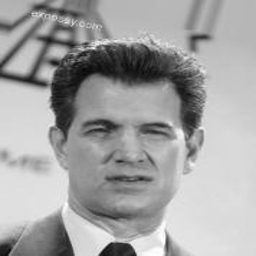

In [80]:
PIL.Image.fromarray(arr.astype(np.uint8))

In [32]:
ls datasets/img_align_celeba/ | head

000001.jpg
000002.jpg
000003.jpg
000004.jpg
000005.jpg
000006.jpg
000007.jpg
000008.jpg
000009.jpg
000010.jpg


## Convert to CoreML

In [104]:
! pip install coremltools
! pip install keras==2.2.4
! pip install tensorflow==1.14.0

     |████████████████████████████████| 3.4MB 4.8MB/s 


In [1]:
import coremltools
coreml_model = coremltools.converters.keras.convert('generator.h5', add_custom_layers=True)

# Saving the Core ML model to a file.
coreml_model.save('colorizer.mlmodel')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


0 : input_13, <keras.engine.input_layer.InputLayer object at 0x7f30d6fb9128>
1 : conv2d_134, <keras.layers.convolutional.Conv2D object at 0x7f30d6fb9198>
2 : activation_56, <keras.layers.core.Activation object at 0x7f30d6fb9390>
3 : conv2d_135, <keras.layers.convolutional.Conv2D object at 0x7f30d6fb9518>
4 : activation_57, <keras.layers.core.Activation object at 0x7f30d6fb95f8>
5 : batch_normalization_121, <keras.layers.normalization.BatchNormalization object at 0x7f30d6fb9828>
6 : conv2d_136, <keras.layers.convolutional.Conv2D object at 0x7f30d6fb9860>
7 : batch_normalization_122, <keras.layers.normalization.BatchNormalization object at 0x7f30d6fb9978>
8 : add_52, <keras.layers.merge.Add object at 0x7f30d6fb9b00>
9 : conv2d_137, <keras.layers.convolutional.Conv2D object at 0x7f30d6fb9c18>
10 : activation_58, <keras.layers.core.Activation object at 0x7f30d6fb9c50>
11 : batch_normalization_123, <keras.layers.normalization.BatchNormalization object at 0x7f30d6fb9dd8>
12 : conv2d_138, <ke

In [0]:
generator.save('generator.h5')